## Important Info: Estimate the verification accuracy of DAC for project data
- Used DAC(RP projected) data to train an NN model
- There are 193 different user's profiles and each profiles has 1000 data samples (normalized data)
- Devide all profiles in two groups: training  profile (96) and auxilary profiles (96) 
- Each auxilary data semple has 65 different features and RP prjection moved them to 56 features
- Random matrix of RP follow following distributions: Pr(x=+1)= 1/2s; Pr(x=-1)= 1/2s, Pr(x=0)= 1-1/s where s=3
- The value of dimension reduction k is calculated by k= [(4+2\beta)/(\epsolon^2/2+\epsolon^3/2)]log (n) where n is total sample in a profile and \epsolon,\beta>0
- Construct a NN regressor has 4 dense layers along with 'BatchNormalization' and 'relu' activation funcation
- Last layer is sigmoid function. Input dimension of model is 65 and output dimension 56.
- Trained regressor to recover the plain data from the projected data for the 96 auxilary data classes
- This traind regressor will be used to recove the training data of classifer.
- Let say attacker has the access of RP data of original data and their corresponding label. Attacker can find it by model inversion attack

- Included a summary of the NN architecture
- Need shallow as RP make users profile more distinct
- For 10 rounds of training training accurach reached to 100.0% and validation accuracy reached to 100.0%
- Included a graph that shows change of training and validation acccruacy in different ephocs
- Test accruacy 100.0%

In [1]:
#Read all data [194 users' oversampled data]
import csv
import pandas as pd
dataset=pd.read_csv('Dataset/OversampledDACData.csv',index_col=0)
dataset.head()

,1,2,3,4,5,6,7,8,9,10,...,57,58,59,60,61,62,63,64,65,Label
0,0.178862,0.316667,0.251082,0.144628,0.366255,0.323770,0.065844,0.020243,0.032129,0.060729,...,0.732435,0.736285,0.734870,0.707042,0.131098,0.196,1.0,0.279070,0.016393,0
1,0.166667,0.108333,0.069264,0.074380,0.246914,0.327869,0.213992,0.198381,0.116466,0.085020,...,0.670837,0.671800,0.670509,0.651643,0.170732,0.156,0.0,0.209302,0.234973,0
2,0.162602,0.112500,0.510823,0.280992,0.213992,0.040984,0.086420,0.052632,0.184739,0.259109,...,0.651588,0.651588,0.657061,0.642254,0.320122,0.124,0.0,0.186047,0.327869,0
3,0.085366,0.045833,0.025974,0.045455,0.181070,0.090164,0.045267,0.194332,0.188755,0.323887,...,0.641963,0.641963,0.645533,0.635681,0.204268,0.080,1.0,0.325581,0.054645,0
4,0.512195,0.295833,0.220779,0.247934,0.378601,0.069672,0.600823,0.785425,0.465863,0.477733,...,0.727623,0.732435,0.731028,0.694836,0.173780,0.504,0.0,0.255814,0.245902,0


In [2]:
#replace the user ID by class name and count the number of sample in each class
#dataset['Label'] = pd.factorize(dataset['Label'])[0]
dataset.groupby(['Label'])['Label'].count()

Label
0      300
1      300
2      300
3      300
4      300
      ... 
188    300
189    300
190    300
191    300
192    300
Name: Label, Length: 193, dtype: int64

In [3]:
#seperate the profile in two groups: (i) Training profile (0-95), and (ii) auxiliary profile (96-193)
totalUser= len(pd.unique(dataset['Label']))
trainingData = dataset[dataset['Label'] < 155]
attackData = dataset[dataset['Label'] >= 155]
print("Total user in training dataset:", len(pd.unique(trainingData['Label'])))
print("Total user in auxiliary dataset:", len(pd.unique(attackData['Label'])))

Total user in training dataset: 155
Total user in auxiliary dataset: 38


In [4]:
#value range of training data
print(trainingData.max())

1          1.000000
2          1.000000
3          0.991342
4          1.000000
5          0.967078
            ...    
62         1.000000
63         1.000000
64         1.000000
65         0.874317
Label    154.000000
Length: 66, dtype: float64


# When attacker only knows the distribution of R, attacker will train the attack model by the reandom projected attack data that are train by random generated RP

In [5]:
#Random project the auxiliary dataset
import numpy as np
from sklearn.random_projection import SparseRandomProjection

column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56','Label']
column2=column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56']
attackDataRP = pd.DataFrame(columns=column1)
for seed in range(155,193):
    rng = np.random.RandomState(seed)
    X = attackData[attackData['Label']==seed]
    transformer = SparseRandomProjection(n_components=56, random_state=rng)
    Xdata=X.drop(columns=['Label'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['Label']=seed
    attackDataRP = pd.concat([attackDataRP, XRP], ignore_index=True)
    #print(auxilaryDataRP)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(attackData.shape)
print(attackDataRP.shape)


C:\Users\mdmor\AppData\Local\Temp\ipykernel_22432\4128647647.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  attackDataRP = pd.concat([attackDataRP, XRP], ignore_index=True)


(11400, 66)
(11400, 57)


In [6]:
#user id in auxilary data
print(attackDataRP['Label'])

0        155.0
1        155.0
2        155.0
3        155.0
4        155.0
         ...  
11395    192.0
11396    192.0
11397    192.0
11398    192.0
11399    192.0
Name: Label, Length: 11400, dtype: float64


In [7]:
#Prepare the traning data for training and testing the attacker's model
import tensorflow
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Xdata=attackData.drop(columns=['Label'])
XRPdata=attackDataRP.drop(columns=['Label'])


Xtrain, Xval, XRPtrain, XRPval = train_test_split(Xdata, XRPdata, test_size=0.2, random_state=22)
#Xtrain, Xval, XRPtrain, XRPval = train_test_split(Xtrain, XRPtrain, test_size=0.3, random_state=22)

In [8]:
print(Xtrain.shape)
print(XRPtrain.shape)
#print(Xtest.shape)
#print(XRPtest.shape)
print(Xval.shape)
print(XRPval.shape)

(9120, 65)
(9120, 56)
(2280, 65)
(2280, 56)


In [9]:
# import all necessary package for a neural network
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inlineimport keras
from keras.layers import Dense, Dropout, Input,Activation,Dropout, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
#from tqdm import tqdm
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
#import torch.nn.functional as F

In [10]:
#define optimizers for neural network
from keras.optimizers import SGD, RMSprop, Adam
def adam_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

def RMSprop_optimizer():
    return RMSprop(learning_rate=0.001, rho=0.9)

In [12]:
#neural network architecture for training a regressor

def create_Regressor(release=False,outDim=65):
  classifier = Sequential()
  classifier.add(Dense(128, input_dim=56))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))
  #classifier.add(Dropout(0.2))
   
  #classifier.add(Dense(256))
  #classifier.add(BatchNormalization())
  #classifier.add(Activation('relu'))

  classifier.add(Dense(256))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))
  #classifier.add(Dropout(0.2))

  classifier.add(Dense(256))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))
  #classifier.add(Dropout(0.2))

  #classifier.add(Dense(256))
  #classifier.add(BatchNormalization())
  #classifier.add(Activation('relu'))

  classifier.add(Dense(128))
  classifier.add(BatchNormalization())
  classifier.add(Activation('relu'))
  #classifier.add(Dropout(0.2))

  #if release:
  classifier.add(Dense(outDim, activation='sigmoid'))
  #else:
  #   classifier.add(Dense(Tuser))
  #np.log_softmax_v2(a, axis=axis)
  #classifier.add(F.softmax(a, dim=1))

  classifier.compile(loss='mean_squared_error', optimizer='SGD',metrics=['mean_squared_error'])
  return classifier

Clasf=create_Regressor()
Clasf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 65)             │         8,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,465 (587.75 KB)

 Trainable params: 148,929 (581.75 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [14]:
#Train the regressor  by auxilary dataset
# Input: Projected data
# Output: Plain data
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5,min_lr=0.0001)
callbacks_list = [learning_rate_reduction]

Regressor= create_Regressor(True,65)

#------Comment will start from here
lossc='mean_squared_error'
optimizerc=RMSprop(learning_rate=0.001, rho=0.9)
Regressor.compile(loss=lossc, optimizer=optimizerc,metrics=['mean_squared_error'])
#------Comments will end from here
Rhistoryc2 =  Regressor.fit(XRPtrain, Xtrain, batch_size=64, epochs=10, validation_data=(XRPval, Xval),verbose=1)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.00

# Test the model by pre-seperated data 

In [15]:
#read the test data and seperate test data
import csv
import pandas as pd
testattackdata=pd.read_csv('Dataset/DACDatatest.csv',index_col=0)
testattackdata = testattackdata[testattackdata['Label'] >= 155]
#testdataset.head()

In [16]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection

column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56','Label']
column2=column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56']


testattackDataRP = pd.DataFrame(columns=column1)
for seed in range(155,193):
    rng = np.random.RandomState(seed)
    X = testattackdata[testattackdata['Label']==seed]
    transformer = SparseRandomProjection(n_components=56, random_state=rng)
    Xdata=X.drop(columns=['Label'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['Label']=seed
    testattackDataRP = pd.concat([testattackDataRP, XRP], ignore_index=True)
    #print(auxilaryDataRP)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(testattackdata.shape)
print(testattackDataRP.shape)

C:\Users\mdmor\AppData\Local\Temp\ipykernel_22432\233514233.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  testattackDataRP = pd.concat([testattackDataRP, XRP], ignore_index=True)


(1003, 66)
(1003, 57)


In [17]:
testattackdata=testattackdata.drop(columns=['Label'])
testattackDataRP=testattackDataRP.drop(columns=['Label'])

In [18]:
#Performance of the trained attacker regressor
loss, accuracy = Regressor.evaluate(testattackDataRP, testattackdata)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0752 - mean_squared_error: 0.0752
Loss: 0.07463707774877548
Accuracy: 0.07463707774877548


# Let say attacker has the access of Random projected data of the original data profiles

In [19]:
#RP of original trained data. Let say attacker has the access of RP data of original data
import numpy as np
from sklearn.random_projection import SparseRandomProjection

column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56','ID']
column2=column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56']
trainingDataRP = pd.DataFrame(columns=column1)
for seed in range(0,155):
    rng = np.random.RandomState(seed)
    X = trainingData[trainingData['Label']==seed]
    transformer = SparseRandomProjection(n_components=56, random_state=rng)
    Xdata=X.drop(columns=['Label'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['Label']=seed
    trainingDataRP = pd.concat([trainingDataRP, XRP], ignore_index=True)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(trainingData.shape)
print(trainingDataRP.shape)

C:\Users\mdmor\AppData\Local\Temp\ipykernel_22432\470342661.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trainingDataRP = pd.concat([trainingDataRP, XRP], ignore_index=True)


(46540, 66)
(46540, 57)


In [20]:
#user id in original projected data
print(trainingDataRP['Label'])

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
46535    154.0
46536    154.0
46537    154.0
46538    154.0
46539    154.0
Name: Label, Length: 46540, dtype: float64


In [21]:
#Prediction of plain data by the attacker mdoel assuming that attacker has access of projected data
tDataRP=trainingDataRP.drop(columns=['Label'])
tDataReg= Regressor.predict(tDataRP)
print(tDataReg.shape)

1455/1455 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
(46540, 65)


In [22]:
#assume that along with project data attacker know the label of the data.
# Add id with recovered data
print(type(tDataReg))
print(type(trainingDataRP['Label'].to_numpy()))
traningdataReg = pd.concat([pd.DataFrame(tDataReg), trainingDataRP['Label'].to_frame()], axis=1)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [23]:
# recovered data by the attacker model from projected data
print(traningdataReg.shape)

(46540, 66)


# To test the qulity of recover data we did this experiment

In [24]:
traningdataReg.columns=list(trainingData.columns)
print(traningdataReg)

              1         2         3         4         5         6         7  \
0      0.507760  0.448571  0.312789  0.394282  0.349583  0.281651  0.440891   
1      0.327379  0.314067  0.207835  0.294800  0.225650  0.225861  0.465205   
2      0.321946  0.277095  0.312769  0.305615  0.200325  0.204391  0.420286   
3      0.259044  0.289822  0.181204  0.262085  0.149847  0.172233  0.238121   
4      0.338742  0.328639  0.273115  0.266288  0.194453  0.256723  0.401408   
...         ...       ...       ...       ...       ...       ...       ...   
46535  0.318575  0.278306  0.223269  0.224521  0.090585  0.382490  0.144079   
46536  0.242274  0.275417  0.235705  0.242678  0.121126  0.378494  0.152654   
46537  0.242439  0.296302  0.284998  0.229829  0.108278  0.336655  0.186163   
46538  0.294658  0.232413  0.177092  0.184336  0.093163  0.313628  0.128370   
46539  0.243811  0.191714  0.156988  0.176426  0.061750  0.261868  0.105030   

              8         9        10  ...        57 

In [25]:
import numpy as np
from scipy import stats
allPvalue=np.zeros((155,193))
for id in range(0,155):
    dataset1=traningdataReg[traningdataReg['Label']==id]
    dataset2=trainingData[trainingData['Label']==id]
    for col in range (0,65):
        sample1=dataset1.iloc[:,col]
        sample2=dataset2.iloc[:,col]
        statistics, allPvalue[id,col]=stats.kstest(sample1, sample2)

In [26]:
print(allPvalue)

[[2.28239769e-079 7.29126583e-088 6.81359615e-039 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.20242298e-038 1.74556464e-024 1.16263721e-018 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [2.51496787e-018 1.40833051e-074 2.87676532e-010 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [9.20636237e-061 1.67098241e-071 1.48641150e-078 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [8.66702156e-068 3.16051840e-094 4.46166537e-150 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.86743629e-091 6.47616112e-065 1.66202465e-055 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


In [27]:
allPvalue = np.where(allPvalue < 0.05, 0, 1)
#allPvalue[allPvalue < 0.05] = 0
print(allPvalue)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [28]:
print(np.sum(allPvalue, axis=1))
print(len(allPvalue))

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
155


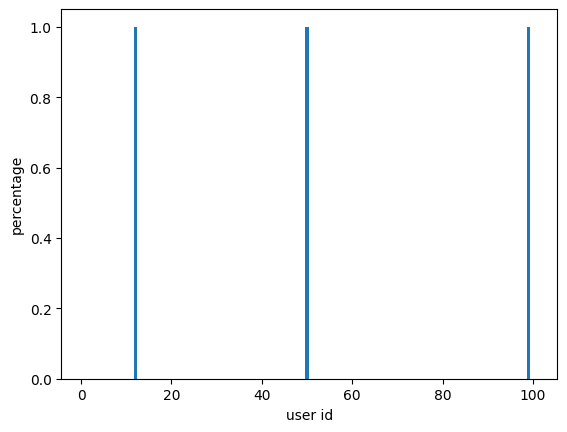

In [29]:
import matplotlib.pyplot as plt
data=np.sum(allPvalue, axis=1)
data=data[0:100]
index=[i for i in range (1,len(data)+1)]
plt.bar(index, data)
plt.xlabel('user id')
plt.ylabel('percentage')
#plt.title('Total features in a profile (out of 65 features) that passed the similarity test')
plt.show()

# End of program

In [98]:
#Random project the recover data to impersonate the user. Used different seed
import numpy as np
from sklearn.random_projection import SparseRandomProjection
#traningdataReg = pd.concat([tDataReg, trainingDataRP['ID']], axis=1)
column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56','ID']
column2=column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56']
traningdataReg.columns=dataset.columns
trainingDataRPReg = pd.DataFrame(columns=column1)
for seed in range(0,96):
    rng = np.random.RandomState(seed+10)
    X = traningdataReg[traningdataReg['ID']==seed]
    transformer = SparseRandomProjection(n_components=56, random_state=rng)
    Xdata=X.drop(columns=['ID'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['ID']=seed
    trainingDataRPReg = pd.concat([trainingDataRPReg, XRP], ignore_index=True)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(traningdataReg.shape)
print(trainingDataRPReg.shape)

(97999, 66)
(97999, 57)


In [99]:
print("Total user in test dataset:", len(pd.unique(trainingDataRPReg['ID'])))

Total user in test dataset: 96


In [100]:
#Performance of the attacker by using the random projected recover data
#UserModel.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
Xtest=trainingDataRPReg.drop(columns=['ID'])
ytest=trainingDataRPReg['ID']
ytest=to_categorical(ytest)
loss, accuracy = TrainedClassifier.evaluate(Xtest,ytest)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

3063/3063 [==============================] - 4s 1ms/step - loss: 19.9066 - accuracy: 0.0000e+00
Loss: 19.906648635864258
Accuracy: 0.0


In [101]:
#Random project the recover data to impersonate the user. If the attacker know the key
import numpy as np
from sklearn.random_projection import SparseRandomProjection
#traningdataReg = pd.concat([tDataReg, trainingDataRP['ID']], axis=1)
column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56','ID']
column2=column1=['RPF1','RPF2','RPF3','RPF4','RPF5','RPF6','RPF7','RPF8','RPF9','RPF10','RPF11','RPF12','RPF13','RPF14','RPF15',
         'RPF16','RPF17','RPF18','RPF19','RPF20','RPF21','RPF22','RPF23','RPF24','RPF25','RPF26','RPF27','RPF28','RPF29','RPF30',
         'RPF31','RPF32','RPF33','RPF34','RPF35','RPF36','RPF37','RPF38','RPF39','RPF40','RPF41','RPF42','RPF43','RPF44','RPF45',
         'RPF46','RPF47','RPF48','RPF49','RPF50','RPF51','RPF52','RPF53','RPF54','RPF55','RPF56']
traningdataReg.columns=dataset.columns
trainingDataRPReg = pd.DataFrame(columns=column1)
for seed in range(0,96):
    rng = np.random.RandomState(seed)
    X = traningdataReg[traningdataReg['ID']==seed]
    transformer = SparseRandomProjection(n_components=56, random_state=rng)
    Xdata=X.drop(columns=['ID'])
    XRP = pd.DataFrame(transformer.fit_transform(Xdata),columns=column2)
    XRP['ID']=seed
    trainingDataRPReg = pd.concat([trainingDataRPReg, XRP], ignore_index=True)
    #print("Shape of Actual data:",Xdata.shape)
    #print("Shape of Randome Matrix:", transformer.components_.shape[1],transformer.components_.shape[0])
    #print("Shape of Projected data:", X_new.shape)
print(traningdataReg.shape)
print(trainingDataRPReg.shape)

(97999, 66)
(97999, 57)


In [102]:
#Performance of the attacker by using the random projected recover data when key is known
#UserModel.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])
Xtest=trainingDataRPReg.drop(columns=['ID'])
ytest=trainingDataRPReg['ID']
ytest=to_categorical(ytest)
loss, accuracy = TrainedClassifier.evaluate(Xtest,ytest)
#print('Test score:', score)
print('Loss:', loss)
print('Accuracy:', accuracy)

3063/3063 [==============================] - 4s 1ms/step - loss: 0.1201 - accuracy: 0.9698
Loss: 0.12010253220796585
Accuracy: 0.969836413860321
